# The 2-Qubit Design, Version 3 has 4 sets of FXTFX design

### Changes with this design
#### Version 3.1 has
* fbl_sep='10um', (version 3 had 30um)
* cpw_width ='10um',
* cpw_gap = '8.409um',

#### - Resonator frequencies were starting from 6.8 and go as following 7.2, 7.6 and 8.0 GHz, with V.1 and V.2. Here, we have 8 resonators in total. TODO: add the rest res freq too
#### - Launch pads and all the resonator etc set to 45 Ohm (check new gap values!)

### 1. The Maxwell Capacitance Matrix
#### 1a.Calculations of Q_c and Kappa

### 2. EPR simulations-will be added

### 3. Creating the GDS file

### Preparations

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
import matplotlib.pyplot as plt

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.qubits.fluxonium_v2 import FluxoniumPocket
from qiskit_metal.qlibrary.qubits.fluxonium_withJJ import FluxoniumPocket

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping

import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis 

In [2]:
# Each time you create a new quantum circuit design,
# you start by instantiating a QDesign class.

# The design class `DesignPlanar` is best for 2D circuit designs.
design = designs.DesignPlanar()
design.chips.main.material = 'silicon'  # our substrate is Silicon
# cpw_width and cpw_gap is defined from the beginnning if you need you can 
# change it later. But with this way one can be sure all the lines are having same width and gap.
design.variables['cpw_width'] = '15 um'  
design.variables['cpw_gap'] = '5.909 um' # was 8.733um, this value is set for 45Ohm launch pads and the resonators. 
design._chips['main']['size']['size_x'] = '9mm'  # Our device size is 9*9mm
design._chips['main']['size']['size_y'] = '9mm'
design._chips['main']['size']['size_z'] = '-525um' #Our wafer thicknes is 525 um+/-10

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# run the GUI 
gui = MetalGUI(design)

In [3]:
from qiskit_metal.qlibrary.terminations.ebeam_marker_v2 import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame
## Markers for ebeam
options = dict(pos_x='3.95mm', pos_y='4.25mm')
mrk1 = Markers(design, 'marker1', options = options)
options = dict(pos_x='-3.95mm', pos_y='4.25mm')
mrk2 = Markers(design, 'marker2', options = options)
options = dict(pos_x='-3.95mm', pos_y='-4.25mm')
mrk3 = Markers(design, 'marker3', options = options)
options = dict(pos_x='3.95mm', pos_y='-4.25mm')
mrk4 = Markers(design, 'marker4', options = options)

options = dict(chip='main', f_gap='140um',)
frame = Frame(design, 'frame', options = options)
gui.rebuild()

In [4]:
#Setup the launchpad1 location and orientation

## Read In launch pad
launch_options = dict(chip='main', pos_x='0.0mm', pos_y='4.0mm', orientation='270',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='0.0mm', pos_y='-4.0mm', orientation='90',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)


Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {#'start_straight': '3970um', 'end_straight': '3970um',
                    # 'start_jogged_extension': jogs_in,
                    # 'anchors': anchors1,
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)

gui.rebuild()

In [5]:
# Q1 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-2.2mm', pos_y='-4.0mm', orientation='90',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB1', options = launch_options)
launch_options = dict(chip='main', pos_x='-3.3mm', pos_y='-4.0mm', orientation='90',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL1', options = launch_options) #change line

# Q3 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-2.75mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB3', options = launch_options) #flux line

# Q2 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-1.65mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL2', options = launch_options) #flux line
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-0.55mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB2', options = launch_options) #charge line

# Q4 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='0.55mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB4', options = launch_options) #change line
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='1.65mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL4', options = launch_options) #flux line

# Q6 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='2.75mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB6', options = launch_options) #flux line

# Q5 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-3.3mm', pos_y='4.0mm', orientation='270',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL5', options = launch_options) #change line

launch_options = dict(chip='main', pos_x='-2.2mm', pos_y='4.0mm', orientation='270',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB5', options = launch_options) #flux line


gui.rebuild()

In [6]:
# Q7 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='2.2mm', pos_y='4.0mm', orientation='270',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB7', options = launch_options)
launch_options = dict(chip='main', pos_x='3.3mm', pos_y='4.0mm', orientation='270',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL7', options = launch_options) #change line

# Q9 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='2.75mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB9', options = launch_options) #flux line

# Q8 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='1.65mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL8', options = launch_options) #flux line

launch_options = dict(chip='main', pos_x='4.0mm', pos_y='0.55mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB8', options = launch_options) #charge line

# Q10 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-0.55mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB10', options = launch_options) #change line
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-1.65mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL10', options = launch_options) #flux line

# Q12 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-2.75mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB12', options = launch_options) #flux line

# Q11 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='3.3mm', pos_y='-4.0mm', orientation='90',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL11', options = launch_options) #change line
launch_options = dict(chip='main', pos_x='2.2mm', pos_y='-4.0mm', orientation='90',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB11', options = launch_options) #flux line


gui.rebuild()

In [7]:
from qiskit_metal.qlibrary.qubits.fluxonium_withJJ import FluxoniumPocket

gds_cell_name_jj = 'junction_1'

## Every qubit options are slightly different than each other, that's why I seperated them. 
# Q1 details
pos_x1and2= '-2.3mm' #Qubit 1 and 2 has to be on the same x position
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False, jj_length='10um',
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1', 
                    
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True)
              )

q1 = FluxoniumPocket(design,'Q1', options = dict(pos_x = pos_x1and2, pos_y = '-2.270mm',orientation =270,
        **options))

# Q2 details
gds_cell_name_jj = 'junction_1'
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False,  jj_length='10um',
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor , 
               inductor_orientation='-1', jj_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um' # was '11.233um'
                               ),
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q2 = FluxoniumPocket(design,'Q2', options = dict(pos_x = pos_x1and2, pos_y = '-1.30mm',orientation =90,
             **options))

pos_x4and5= '-2.25mm' #Qubit 4 and 5 has to be on the same x position
# Q4 details
gds_cell_name_jj = 'junction_1'
gds_cell_name_inductor = 'jj_array_v2_0' 
options = dict(chip='main', nanowire = False, jj_length='10um',
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1', 
                    
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True)
              )

q4 = FluxoniumPocket(design,'Q4', options = dict(pos_x = pos_x4and5, pos_y = '1.515mm',orientation =270,
        **options))

# Q5 details
gds_cell_name_jj = 'junction_1'
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False,  jj_length='10um',
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor , 
               inductor_orientation='-1', jj_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um' # was '11.233um'
                               ),
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q5 = FluxoniumPocket(design,'Q5', options = dict(pos_x = pos_x4and5, pos_y = '2.485mm',orientation =90,
             **options))


gui.rebuild()
gui.autoscale()

In [8]:
from qiskit_metal.qlibrary.qubits.tmon_c import Tmon_c
gds_cell_name_jj = 'junction_t0'

# Qc-3 details
#pos_x3= '-2.3mm'-'0.16mm'
options = dict(jj_gap ='30um', pad_arm_length='810um', pad_head_length='400um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,      
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='10um',
                                cpw_width ='10um',
            cpw_gap = '8.409um',
                            fbl_length = '100um'), 
                                 )
               
# Create a new Transmon Cross object with name 'Q3'
q3 = Tmon_c(design, 'Q3', options=dict(pos_x = '-2.46mm', pos_y = '-1.785mm', 
                                       orientation='90',
                                             **options))
# Qc-6 details
gds_cell_name_jj = 'junction_t0'
options = dict(jj_gap ='30um', pad_arm_length='810um', pad_head_length='400um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='10um',
                                cpw_width ='10um',
            cpw_gap = '8.409um',
                            fbl_length = '100um'), 
                                 )
q6 = Tmon_c(design, 'Q6', options=dict(pos_x = '-2.41mm', pos_y = '2.0mm', 
                                       orientation='90',
                                             **options))

gui.rebuild()  # rebuild the design and plot
#gui.autoscale() #resize GUI to see QComponent

In [9]:
from qiskit_metal.qlibrary.qubits.tmon_c import Tmon_c
gds_cell_name_jj = 'junction_t1'

# Qc-9 details
options = dict(jj_gap ='30um', pad_arm_length='810um', pad_head_length='400um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,      
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='10um', 
                                cpw_width ='10um',
            cpw_gap = '8.409um',
                            fbl_length = '100um'), 
                                 )
               
# Create a new Transmon Cross object with name 'Q3'
q9 = Tmon_c(design, 'Q9', options=dict(pos_x = '2.56mm', pos_y = '2.0mm', 
                                       orientation='270',
                                             **options))
# Qc-12 details
gds_cell_name_jj = 'junction_t1'
options = dict(jj_gap ='30um', pad_arm_length='810um', pad_head_length='400um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='10um', 
                     cpw_width ='10um',
            cpw_gap = '8.409um',
                            fbl_length = '100um'), 
                                 )
q12 = Tmon_c(design, 'Q12', options=dict(pos_x = '2.56mm', pos_y = '-2.0mm', 
                                       orientation='270',
                                             **options))

gui.rebuild()  # rebuild the design and plot
#gui.autoscale() #resize GUI to see QComponent

In [10]:
from qiskit_metal.qlibrary.qubits.fluxonium_withJJ import FluxoniumPocket

gds_cell_name_jj = 'junction_2'

## Every qubit options are slightly different than each other, that's why I seperated them. 
# Q7 details
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False,    jj_length='10um',           
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', jj_orientation='-1',
                    
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True) 
              )

q7 = FluxoniumPocket(design,'Q7', options = dict(pos_x = '2.4mm', pos_y = '2.485mm',orientation =90,
        **options))

               
# Q8 details 
gds_cell_name_jj = 'junction_2'
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False, 
            gds_cell_name=gds_cell_name_jj, jj_length='10um',
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', 
                           
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'), 
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q8 = FluxoniumPocket(design,'Q8', options = dict(pos_x = '2.4mm', pos_y = '1.515mm',orientation =270,
             **options))

# Q10 details
gds_cell_name_jj = 'junction_3'
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False,  jj_length='10um',             
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', jj_orientation='-1',
                    
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True) 
              )

q10 = FluxoniumPocket(design,'Q10', options = dict(pos_x = '2.4mm', pos_y = '-1.515mm',orientation =90,
        **options))

               
# Q11 details  
gds_cell_name_jj = 'junction_3'
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False, 
            gds_cell_name=gds_cell_name_jj, jj_length='10um',
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', 
                           
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'), 
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q11 = FluxoniumPocket(design,'Q11', options = dict(pos_x = '2.4mm', pos_y = '-2.485mm',orientation =270,
             **options))

gui.rebuild()
#gui.autoscale()

### fix the q pos x and then run gates

In [11]:
# Lambda/2 resonators - Resonator1
from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', 
                 pos_x='-32.0um', pos_y='-2.12mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity1',  Dict(meander=Dict(spacing='200um'),
        total_length='8.69mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1450um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='Q1', pin='readout_line')), ))

# Lambda/2 resonators - Resonator2
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg2 = OpenToGround(design, 'otg2s', options=dict(chip='main', 
                 pos_x='-32.0um', pos_y='-0.4mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity2',  Dict(meander=Dict(spacing='200um'),
        total_length='8.195mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1350um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg2s', pin='open'),
            end_pin=Dict(component='Q2', pin='readout_line')), ))

# Lambda/2 resonators - Resonator4
jogs_in = OrderedDict()
jogs_in[0] = ["L", '200um']
jogs_in[1] = ["L", '200um']

otg4 = OpenToGround(design, 'otg4s', options=dict(chip='main', 
                    pos_x='-32.0um',  pos_y='0.5mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity4',  Dict(meander=Dict(spacing='200um'),
        total_length='7.78mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1250um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg4s', pin='open'),
            end_pin=Dict(component='Q4', pin='readout_line')), ))

# Lambda/2 resonators - Resonator5
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg5= OpenToGround(design, 'otg5s', options=dict(chip='main', 
                 pos_x='-32.0um', pos_y='3.7mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity5',  Dict(meander=Dict(spacing='200um'),
        total_length='7.38mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1190um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg5s', pin='open'),
            end_pin=Dict(component='Q5', pin='readout_line')), ))

gui.rebuild()

In [12]:
# Lambda/2 resonators - Resonator1
from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg7 = OpenToGround(design, 'otg7s', options=dict(chip='main', 
                 pos_x='31.0um', pos_y='2.0mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity7',  Dict(meander=Dict(spacing='200um'),
        total_length='9.50mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1500um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg7s', pin='open'),
            end_pin=Dict(component='Q7', pin='readout_line')), ))

# Lambda/2 resonators - Resonator2
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg8 = OpenToGround(design, 'otg8s', options=dict(chip='main', 
                 pos_x='29.5um', pos_y='0.3mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity8',  Dict(meander=Dict(spacing='200um'),
        total_length='9.90mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1400um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg8s', pin='open'),
            end_pin=Dict(component='Q8', pin='readout_line')), ))

# Lambda/2 resonators - Resonator4
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg10 = OpenToGround(design, 'otg10s', options=dict(chip='main', 
                    pos_x='29.0um',  pos_y='-1.6mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity10',  Dict(meander=Dict(spacing='200um'),
        total_length='10.6mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1450um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg10s', pin='open'),
            end_pin=Dict(component='Q10', pin='readout_line')), ))

# Lambda/2 resonators - Resonator5
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg11= OpenToGround(design, 'otg11s', options=dict(chip='main', 
                 pos_x='28.8um', pos_y='-3.7mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity11',  Dict(meander=Dict(spacing='200um'),
        total_length='11.40mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1590um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg11s', pin='open'),
            end_pin=Dict(component='Q11', pin='readout_line')), ))

gui.rebuild()

In [13]:
## The test structures: these are for room temp probing!
# Q JJ1 Trial details
gds_cell_name_jj = 'junction_1'
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main',  nanowire = False, jj_orientation='-1',
        orientation =90, pos_x = '-1.0mm', pos_y = '0.7mm',
               pocket_width= '300um',
        gds_cell_name=gds_cell_name_jj, jj_length='10um',
    flux_bias_line_options=Dict(make_fbl = False),
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
qJJ1 = FluxoniumPocket(design,'QJJ1', options = dict(
        **options))
# Q JJ2 Trial details
gds_cell_name_jj = 'junction_2'
options = dict(chip='main', nanowire = False, jj_orientation='-1',
        orientation =90, pos_x = '-1.0mm', pos_y = '0.5mm',
               pocket_width= '300um', jj_length='10um',
        gds_cell_name=gds_cell_name_jj,
    flux_bias_line_options=Dict(make_fbl = False),
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
qJJ2 = FluxoniumPocket(design,'QJJ2', options = dict(
        **options))
# Q JJ3 Trial details
gds_cell_name_jj = 'junction_3'
options = dict(chip='main', nanowire = False, jj_orientation='-1',
        orientation =90, pos_x = '-1.0mm', pos_y = '0.3mm',
               pocket_width= '300um', jj_length='10um',
        gds_cell_name=gds_cell_name_jj,
    flux_bias_line_options=Dict(make_fbl = False),
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
qJJ3 = FluxoniumPocket(design,'QJJ3', options = dict(
        **options))


# Q Array1 details
options = dict(chip='main', nanowire = False, jj_length='10um',
            orientation =90, pos_x = '-1.0mm', pos_y = '0.1mm',
            gds_cell_inductor=gds_cell_name_inductor , pocket_width= '300um',
               inductor_orientation='-1',
    flux_bias_line_options=Dict(make_fbl = False,
                        ),
    charge_line_options=Dict(loc_H = +1, make_cl = False,
               ),
    readout_line_options=Dict(loc_H = -1, make_rol = False,
              ) )
qArr1 = FluxoniumPocket(design,'QArr1', options = dict(
             **options))
# Q Array2 Trial details
options = dict(chip='main', nanowire = False, jj_length='10um',
        orientation =90, pos_x = '-1.0mm', pos_y = '-0.1mm',
               pocket_width= '300um',
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
    flux_bias_line_options=Dict(make_fbl = False,
                               ),
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False,
              ) )
qArr2 = FluxoniumPocket(design,'QArr2', options = dict(
        **options))
# Q Array3 Trial details
options = dict(chip='main', nanowire = False, jj_length='10um',
        orientation =90, pos_x = '-1.0mm', pos_y = '-0.3mm',
               pocket_width= '300um',
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
    flux_bias_line_options=Dict(make_fbl = False,
                      ),
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False,
              ) )
qArr3 = FluxoniumPocket(design,'QArr3', options = dict(
        **options))
# Tmon Trial details
gds_cell_name_jj = 'junction_t0'
options = dict(jj_gap ='30um', pad_arm_length='210um', pad_head_length='100um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = False, fbl_sep='30um', 
                            fbl_length = '100um'), 
                                 )
qTmon1 = Tmon_c(design, 'QTmon1', options=dict(pos_x = '-1.5mm', pos_y = '0.6mm', 
                                       orientation='90',
                                             **options))
# Tmon2 Trial details
gds_cell_name_jj = 'junction_t0'
options = dict(jj_gap ='30um', pad_arm_length='210um', pad_head_length='100um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = False, fbl_sep='30um', 
                            fbl_length = '100um'), 
                                 )
qTmon2 = Tmon_c(design, 'QTmon2', options=dict(pos_x = '-1.5mm', pos_y = '0.2mm', 
                                       orientation='90',
                                             **options))
# Tmon3 Trial details
gds_cell_name_jj = 'junction_t0'
options = dict(jj_gap ='30um', pad_arm_length='210um', pad_head_length='100um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = False), 
                                 )
qTmon3 = Tmon_c(design, 'QTmon3', options=dict(pos_x = '-1.5mm', pos_y = '-0.2mm', 
                                       orientation='90',
                                             **options))
gui.rebuild()

In [14]:
#Charge Line for Q11
# jogs_in[0] = ["R", '800um']
# jogs_in[1] = ["R", '300um']
# jogs_in[2] = ["L", '200um']
XYCharge_LineQ11 = RoutePathfinder(design, 'XY_Gate11',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='100um', end_straight='100um',
        #start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q11',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL11',
                                            pin='tie')
                                            )))
gui.rebuild()

In [15]:
# Flux Bias Line for Q11
jogs_in = OrderedDict()
jogs_in[0] = ["R", '400um']
jogs_in[1] = ["L", '150um']
ZFluxBias_LineQ11 = RoutePathfinder(design, 'Z_Gate11',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='350um', end_straight='200um',
        start_jogged_extension= jogs_in
                     ),
        pin_inputs=Dict(start_pin=Dict(component='Q11',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB11', pin='tie')
                                   )))
gui.rebuild()

In [16]:
# Flux Bias Line for Q12
jogs_in = OrderedDict()
#jogs_in[0] = ["R", '200um']
# jogs_in[1] = ["L", '200um']
ZFluxBias_LineQ12 = RoutePathfinder(design, 'Z_Gate12',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='450um',
       # start_jogged_extension= jogs_in
                     ),
        pin_inputs=Dict(start_pin=Dict(component='LPFB12',
              pin='tie'),
          end_pin=Dict(component='Q12', pin='flux_bias_line')
                                   )))
gui.rebuild()

In [17]:
#Flux Bias Line for Q10
#Charge Line for Q10
jogs_in = OrderedDict()
jogs_in[0] = ["L", '200um']
XYCharge_LineQ10 = RoutePathfinder(design, 'XY_Gate10',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='550um', end_straight='200um', 
        start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q10',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL10',
                                            pin='tie')
                                            )))
                                  
jogs_in = OrderedDict()
jogs_in[0] = ["R", '850um']
# jogs_in[1] = ["R", '450um']
# jogs_in[2] = ["L", '350um']
ZFluxBias_LineQ10 = RoutePathfinder(design, 'Z_Gate10',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um',
        end_straight='200um', 
        start_jogged_extension= jogs_in),
        pin_inputs=Dict(start_pin=Dict(component='Q10',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB10', pin='tie')
                                   )))


gui.rebuild()

In [18]:
#Flux Bias Line for Q8
#Charge Line for Q8
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["L", '250um']
XYCharge_LineQ8 = RoutePathfinder(design, 'XY_Gate8',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um', end_straight='200um', 
        start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q8',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL8',
                                            pin='tie')
                                            )))
                                  
jogs_in = OrderedDict()
jogs_in[0] = ["L", '850um']
ZFluxBias_LineQ8 = RoutePathfinder(design, 'Z_Gate8',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um',
        end_straight='100um', 
        start_jogged_extension= jogs_in),
        pin_inputs=Dict(start_pin=Dict(component='Q8',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB8', pin='tie')
                                   )))


gui.rebuild()

In [19]:
# Flux Bias Line for Q9
# jogs_in = OrderedDict()
# jogs_in[0] = ["R", '200um']
# jogs_in[1] = ["L", '200um']
ZFluxBias_LineQ9 = RoutePathfinder(design, 'Z_Gate9',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um',end_straight='450um',
        #start_jogged_extension= jogs_in
                     ),
        pin_inputs=Dict(start_pin=Dict(component='LPFB9',
              pin='tie'),
          end_pin=Dict(component='Q9', pin='flux_bias_line')
                                   )))
gui.rebuild()

In [20]:
#Flux Bias Line for Q7
#Charge Line for Q7
# jogs_in = OrderedDict()
# jogs_in[0] = ["R", '1200um']
# jogs_in[1] = ["L", '250um']
XYCharge_LineQ7 = RoutePathfinder(design, 'XY_Gate7',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='200um', 
       # start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q7',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL7',
                                            pin='tie')
                                            )))
                                  
jogs_in = OrderedDict()
jogs_in[0] = ["R", '250um']
# jogs_in[1] = ["R", '650um']
# jogs_in[2] = ["L", '100um']
ZFluxBias_LineQ7 = RoutePathfinder(design, 'Z_Gate7',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um',
        end_straight='300um', 
        start_jogged_extension= jogs_in),
        pin_inputs=Dict(start_pin=Dict(component='Q7',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB7', pin='tie')
                                   )))


gui.rebuild()

In [21]:
# Flux Bias Line for Q5
jogs_in = OrderedDict()
jogs_in[0] = ["R", '300um']
#jogs_in[1] = ["L", '200um']
ZFluxBias_LineQ5 = RoutePathfinder(design, 'Z_Gate5',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='350um', end_straight='200um',
        start_jogged_extension= jogs_in
                     ),
        pin_inputs=Dict(start_pin=Dict(component='Q5',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB5', pin='tie')
                                   )))
gui.rebuild()

In [22]:
#Charge Line for Q5
# jogs_in[0] = ["R", '800um']
# jogs_in[1] = ["R", '200um']
# jogs_in[2] = ["L", '200um']
XYCharge_LineQ5 = RoutePathfinder(design, 'XY_Gate5',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um', end_straight='200um',
      #  start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q5',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL5',
                                            pin='tie')
                                            )))
gui.rebuild()

In [23]:
# Flux Bias Line for Q6
# jogs_in = OrderedDict()
# jogs_in[0] = ["R", '200um']
# jogs_in[1] = ["L", '200um']
ZFluxBias_LineQ6 = RoutePathfinder(design, 'Z_Gate6',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='100um',end_straight='600um',
        #start_jogged_extension= jogs_in
                     ),
        pin_inputs=Dict(start_pin=Dict(component='LPFB6',
              pin='tie'),
          end_pin=Dict(component='Q6', pin='flux_bias_line')
                                   )))
gui.rebuild()

In [24]:
#Flux Bias Line for Q4
#Charge Line for Q4
jogs_in = OrderedDict()
jogs_in[0] = ["L", '300um']
jogs_in[1] = ["R", '300um']
XYCharge_LineQ4 = RoutePathfinder(design, 'XY_Gate4',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um', end_straight='150um', 
        start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q4',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL4',
                                            pin='tie')
                                            )))
                                  
                                  
jogs_in = OrderedDict()
jogs_in[0] = ["R", '850um']
ZFluxBias_LineQ4 = RoutePathfinder(design, 'Z_Gate4',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um',
        end_straight='100um', 
        start_jogged_extension= jogs_in),
        pin_inputs=Dict(start_pin=Dict(component='Q4',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB4', pin='tie')
                                   )))


gui.rebuild()

In [25]:
# Flux Bias Line for Q11
jogs_in = OrderedDict()
jogs_in[0] = ["L", '500um']
jogs_in[1] = ["R", '300um']
ZFluxBias_LineQ1 = RoutePathfinder(design, 'Z_Gate1',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um', end_straight='200um',
        start_jogged_extension= jogs_in
                     ),
        pin_inputs=Dict(start_pin=Dict(component='Q1',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB1', pin='tie')
                                   )))


# #Charge Line for Q1
# jogs_in[0] = ["R", '400um']
XYCharge_LineQ1 = RoutePathfinder(design, 'XY_Gate1',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='250um', end_straight='150um',
       # start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q1',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL1',
                                            pin='tie')
                                            )))

# Flux Bias Line for Q3
jogs_in[0] = ["L", '400um']
ZFluxBias_LineQ3 = RoutePathfinder(design, 'Z_Gate3', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='350um', end_straight='150um',
                     start_jogged_extension= jogs_in),
        pin_inputs=Dict(start_pin=Dict(component='Q3',
                 pin='flux_bias_line'),
                end_pin=Dict(component='LPFB3',pin='tie')
                                            )))

gui.rebuild()

In [26]:
# Flux Bias Line for Q2
jogs_in = OrderedDict()
jogs_in[0] = ["L", '850um']
# jogs_in[1] = ["R", '1000um']
# jogs_in[2] = ["L", '200um']
ZFluxBias_LineQ2 = RoutePathfinder(design, 'Z_Gate2', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='500um', end_straight='150um',
        start_jogged_extension= jogs_in
                   ),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB2',
                                                    pin='tie')
                                            )))
gui.rebuild()

In [27]:
# #Charge Line for Q2
# jogs_in = OrderedDict()
# jogs_in[0] = ["R", '500um']
# jogs_in[1] = ["L", '100um']
XYCharge_LineQ2 = RoutePathfinder(design, 'XY_Gate2',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='850um', end_straight='250um',
        #start_jogged_extension= jogs_in
                     ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q2',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL2',
                                            pin='tie')
                                            )))
gui.rebuild()

## Maxwell Capacitance Matrix

In [55]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [56]:
# for second method. dont run this
# example: update single setting
c1.sim.setup.max_passes = 20
# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 20,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

In [57]:
# Qubit 5 has the default settings in terms of readout pads and charge line places.
c1.sim.run(components=['Q3'], open_terminations=
           [('Q3', 'flux_bias_line'), ('Q3', 'fake_flux_bias_line')])
c1.sim.capacitance_matrix

INFO 04:31PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:31PM [analyze]: Analyzing setup Setup
INFO 04:33PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp8nksnlpf.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:33PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpvpm5etpx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:33PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpjebs_aw_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:33PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmphovsvzw4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,flux_bias_line_Q3,ground_main_plane,tmon_0_Q3
flux_bias_line_Q3,52.60355,-51.60715,-0.80015
ground_main_plane,-51.60715,289.28387,-174.59768
tmon_0_Q3,-0.80015,-174.59768,177.66406


In [7]:
# Qubit 5 has the default settings in terms of readout pads and charge line places.
c1.sim.run(components=['Q1', 'Q2', 'Q3'], open_terminations=
           [('Q1', 'charge_line'), ('Q1', 'flux_bias_line'), ('Q1', 'fake_flux_bias_line'),('Q1', 'readout_line'),
            ('Q2', 'charge_line'), ('Q2', 'flux_bias_line'), ('Q2', 'fake_flux_bias_line'),('Q2', 'readout_line'),
            ('Q3', 'flux_bias_line'), ('Q3', 'fake_flux_bias_line')])
c1.sim.capacitance_matrix

INFO 05:14PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:14PM [load_ansys_project]: 	Opened Ansys App
INFO 05:14PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 05:14PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/ana/
	Project:   Project81
INFO 05:14PM [connect_design]: No active design found (or error getting active design).
INFO 05:14PM [connect]: 	 Connected to project "Project81". No design detected
INFO 05:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 05:14PM [connect_setup]: 	No design setup detected.
WARNING 05:14PM [connect_setup]: 	Creating Q3D default setup.
INFO 05:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:14PM [analyze]: Analyzing setup Setup
INFO 05:15PM [get_matrix]: Exporting matrix data to (C:\Users\siywa\AppData\Local\Temp\tmp4l2q0zfi.txt, C, ,

,charge_line_Q1,charge_line_Q2,flux_bias_line_Q1,flux_bias_line_Q2,flux_bias_line_Q3,ground_main_plane,pad_bot_Q1,pad_bot_Q2,pad_top_Q1,pad_top_Q2,readout_padNline_Q1,readout_padNline_Q2,tmon_Q3
charge_line_Q1,22.06853,-0.00061,-0.12703,-0.00438,-0.00375,-21.01718,-0.53288,-0.00564,-0.05220,-0.00529,-0.03599,-0.00859,-0.19876
charge_line_Q2,-0.00061,22.06858,-0.00435,-0.12671,-0.00416,-21.01598,-0.00528,-0.05223,-0.00562,-0.53271,-0.00858,-0.03604,-0.19881
flux_bias_line_Q1,-0.12703,-0.00435,59.38361,-0.07666,-0.02342,-45.04294,-4.42463,-0.07468,-4.66449,-0.06308,-2.11121,-0.14149,-1.32191
flux_bias_line_Q2,-0.00438,-0.12671,-0.07666,59.33997,-0.02421,-44.95983,-0.06309,-4.66333,-0.07464,-4.41669,-0.14160,-2.11294,-1.32134
flux_bias_line_Q3,-0.00375,-0.00416,-0.02342,-0.02421,62.92976,-62.17783,-0.02418,-0.01845,-0.01767,-0.02616,-0.02220,-0.02212,-0.50716
ground_main_plane,-21.01718,-21.01598,-45.04294,-44.95983,-62.17783,816.01268,-21.09146,-20.79569,-20.79648,-21.08942,-165.60509,-165.57906,-108.43629
pad_bot_Q1,-0.53288,-0.00528,-4.42463,-0.06309,-0.02418,-21.09146,40.79281,-0.07250,-3.06499,-0.05826,-0.81467,-0.11747,-9.86928
pad_bot_Q2,-0.00564,-0.05223,-0.07468,-4.66333,-0.01845,-20.79569,-0.07250,37.10060,-0.10005,-3.06598,-0.17468,-5.39740,-1.84433
pad_top_Q1,-0.05220,-0.00562,-4.66449,-0.07464,-0.01767,-20.79648,-3.06499,-0.10005,37.10391,-0.07248,-5.39848,-0.17440,-1.84199
pad_top_Q2,-0.00529,-0.53271,-0.06308,-4.41669,-0.02616,-21.08942,-0.05826,-3.06598,-0.07248,40.78766,-0.11751,-0.81507,-9.87204


In [44]:
# Here, the calculation of g (coupling strength between FX1 to FX2)
import numpy as np
e = 1.60217663e-19
hbar = 1.05457182e-34

C1t_c = Cc_1t = Cc_2t = C2t_c = 9.80*10**(-15) ## qubit 1 top pad to coupler
C1b_c = Cc_1b = Cc_2b = C2b_c = 1.83*10**(-15) ## qubit 1 bottom pad to coupler
C1b_gnd = C2b                 = 20.79*10**(-15) ## qubit 1 bottom pad to ground
C1t_gnd = C2t                 = 20.78*10**(-15)  ## qubit 1 top pad to ground
Cc                            = 108.03*10**(-15) ## coupler qubit to ground
C1t_1b= C1b_1t = C2t_2b = C2b_2t = 3.05*10**(-15) 


C11 = C1t_gnd + C1t_1b + C1t_c
C22 = C1b_gnd + C1b_1t + C1b_c
C33 = Cc + Cc_1t + Cc_1b + Cc_2t + Cc_2b
C44 = C2t + C2t_2b + C2t_c
C55 = C2b + C2b_2t + C2b_c

Csigma = C11*C22*C33*C44*C55



g1_2_n=(2*e)**2*((Cc_2t*C55- Cc_2b*C44)*(C1t_1b*(C1b_c-C1t_c)-C11*C1b_c+C1t_c*C22)+C2t_2b*(Cc_2b-Cc_2t)*(-C11*C1b_c+C22*C1t_c))/(hbar*2*np.pi*Csigma)


print('Csigma =', Csigma, 'F')


print('we have g1_2_n/2pi =', g1_2_n, 'Hz')
print('which is, g1_2_n/2pi =', g1_2_n/1e6, 'MHz')

g1_c= (2*e)**2*((C1t_c*C22- C1b_c*C11)+C1t_1b*(C1b_c-C1t_c))/(hbar*2*np.pi*C11*C22*C33)


print('we have g1_c/2pi =', g1_c, 'Hz')
print('which is, g1_c/2pi =', g1_c/1e6, 'MHz')
print()

Csigma = 9.784465816304609e-68 F
we have g1_2_n/2pi = 42556134.152028926 Hz
which is, g1_2_n/2pi = 42.556134152028925 MHz
we have g1_c/2pi = 226569337.51406583 Hz
which is, g1_c/2pi = 226.56933751406584 MHz



In [342]:
from qiskit_metal.analyses.quantization import LOManalysis

c2 = LOManalysis(design, "q3d")
c2.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [343]:
# for second method. dont run this
# example: update single setting
c2.sim.setup.max_passes = 10
# example: update multiple settings
c2.sim.setup_update(solution_order = 'High', auto_increase_solution_order = 'True')

c2.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 10,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'True',
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [347]:
c2.sim.run(components=['TL', 'cavity10'], open_terminations=[('cavity10', 'end'), ('cavity10', 'start'), 
                                                          #   ('cavity2', 'end'), ('cavity2', 'start'), 
                                                             ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 05:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 05:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:05PM [analyze]: Analyzing setup Setup
INFO 05:07PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpggzrdb22.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:07PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp9bsy1xep.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:07PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpad88ga_g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 05:07PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp4hnsbjb_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,g_wb,trace_cavity10,trace_TL
g_wb,3244.07410,-1735.59339,-1288.93441
trace_cavity10,-1735.59339,1774.99038,-37.71266
trace_TL,-1288.93441,-37.71266,1327.98780


In [344]:
## TODO: remove the wire bonds first
c2.sim.run(components=['TL', 'cavity7', 'cavity8', 'cavity10',
                       ], open_terminations=[('cavity7', 'end'), ('cavity7', 'start'),
              ('cavity8', 'end'), ('cavity8', 'start'), ('cavity10', 'end'), ('cavity10', 'start'),
                                             #          ('cavity11', 'end'), ('cavity11', 'start'), 
                                             ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 04:53PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:56PM [analyze]: Analyzing setup Setup
INFO 04:59PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp7_hu6l6z.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:59PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpjw7raafw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:59PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpz2v29ece.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:59PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmprsx8ysmf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,g_wb,trace_cavity7,trace_cavity8,trace_cavity10,trace_TL
g_wb,6546.68680,-1584.47231,-1694.50034,-1777.36131,-1276.26927
trace_cavity7,-1584.47231,1618.17161,-0.22165,-0.00778,-31.49023
trace_cavity8,-1694.50034,-0.22165,1730.79985,-0.15014,-34.36078
trace_cavity10,-1777.36131,-0.00778,-0.15014,1815.65664,-36.43922
trace_TL,-1276.26927,-31.49023,-34.36078,-36.43922,1381.31688


In [348]:
## Lambda/2 resonators- Dressed frequency 
pi=np.pi
Z_0=45.0 # ohm
Z_r=45.0 #ohm

f_1=6.109e9 #Hz
f_2=6.475e9 #Hz
f_4=6.766e9 #Hz
f_5=7.087e9 #Hz

f_7=5.75e9 #Hz
f_8=5.43e9 #Hz
f_10=5.18e9 #Hz
f_11=4.77e9 #Hz

C_1=28.87668e-15 #F
omega_1=2*pi*f_1
Q_c1=pi/(Z_0*Z_r*(C_1*omega_1)**2)
Kappa_1=(f_1/Q_c1)*1e-6

C_2=26.78772e-15 #F
omega_2=2*pi*f_2
Q_c2=pi/(Z_0*Z_r*(C_2*omega_2)**2)
Kappa_2=(f_2/Q_c2)*1e-6

C_4=24.58603e-15 #F
omega_4=2*pi*f_4
Q_c4=pi/(Z_0*Z_r*(C_4*omega_4)**2)
Kappa_4=(f_4/Q_c4)*1e-6

C_5=23.35621e-15 #F
omega_5=2*pi*f_5
Q_c5=pi/(Z_0*Z_r*(C_5*omega_5)**2)
Kappa_5=(f_5/Q_c5)*1e-6

C_7=31.49023e-15 #F
omega_7=2*pi*f_7
Q_c7=pi/(Z_0*Z_r*(C_7*omega_7)**2)
Kappa_7=(f_7/Q_c7)*1e-6

C_8=34.36078e-15 #F
omega_8=2*pi*f_8
Q_c8=pi/(Z_0*Z_r*(C_8*omega_8)**2)
Kappa_8=(f_8/Q_c8)*1e-6

C_10=37.71266e-15 #F
omega_10=2*pi*f_10
Q_c10=pi/(Z_0*Z_r*(C_10*omega_10)**2)
Kappa_10=(f_10/Q_c10)*1e-6

C_11=42.66224e-15 #F
omega_11=2*pi*f_11
Q_c11=pi/(Z_0*Z_r*(C_11*omega_11)**2)
Kappa_11=(f_11/Q_c11)*1e-6

print('Q_c of the R1 is', Q_c1, '')
print('Q_c of the R2 is', Q_c2, '')
print('Q_c of the R4 is', Q_c4, '')
print('Q_c of the R5 is', Q_c5, '')
print()
print('Q_c of the R7 is', Q_c7, '')
print('Q_c of the R8 is', Q_c8, '')
print('Q_c of the R10 is', Q_c10, '')
print('Q_c of the R11 is', Q_c11, '')
print()
print('Kappa of the R1 is', Kappa_1, 'MHz')
print('Kappa of the R2 is', Kappa_2, 'MHz')
print('Kappa of the R4 is', Kappa_4, 'MHz')
print('Kappa of the R5 is', Kappa_5, 'MHz')
print()
print('Kappa of the R7 is', Kappa_7, 'MHz')
print('Kappa of the R8 is', Kappa_8, 'MHz')
print('Kappa of the R10 is', Kappa_10, 'MHz')
print('Kappa of the R11 is', Kappa_11, 'MHz')

Q_c of the R1 is 1262.7876845578903 
Q_c of the R2 is 1306.2131792003486 
Q_c of the R4 is 1420.1175910986271 
Q_c of the R5 is 1434.2851438402479 

Q_c of the R7 is 1198.6096053689687 
Q_c of the R8 is 1128.858276528657 
Q_c of the R10 is 1029.748712151214 
Q_c of the R11 is 948.9449987591298 

Kappa of the R1 is 4.837709517367362 MHz
Kappa of the R2 is 4.957077529997006 MHz
Kappa of the R4 is 4.764394189896421 MHz
Kappa of the R5 is 4.941137423361164 MHz

Kappa of the R7 is 4.797225029937896 MHz
Kappa of the R8 is 4.810169808647503 MHz
Kappa of the R10 is 5.030353462815829 MHz
Kappa of the R11 is 5.026634848423671 MHz


In [242]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [272]:
hfss.open_ansys()

In [273]:
hfss.connect_ansys()

INFO 02:33PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:33PM [load_ansys_project]: 	Opened Ansys App
INFO 02:33PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:33PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    //tudelft.net/staff-homes/Y/figenyilmaz/My Documents/Ansoft/
	Project:   Project21
INFO 02:33PM [connect_design]: 	Opened active design
	Design:    cavity7 [Solution type: Eigenmode]
INFO 02:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:33PM [connect]: 	Connected to project "Project21" and design "cavity7" 😀 



In [276]:
hfss.activate_eigenmode_design("cavity7")

02:33PM 43s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:33PM 43s WARNING [activate_ansys_design]: The design_name=cavity7-2 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity7', 'cavity8', 'Q11_Res11', 'cavity8-2'].  A new design will be added to the project.  
INFO 02:33PM [connect_design]: 	Opened active design
	Design:    cavity7-2 [Solution type: Eigenmode]
WARNING 02:33PM [connect_setup]: 	No design setup detected.
WARNING 02:33PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [277]:
hfss.render_design(['cavity7'], [('cavity7', 'end'), ('cavity7', 'start')])

In [278]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 02:35PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:38PM 00s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


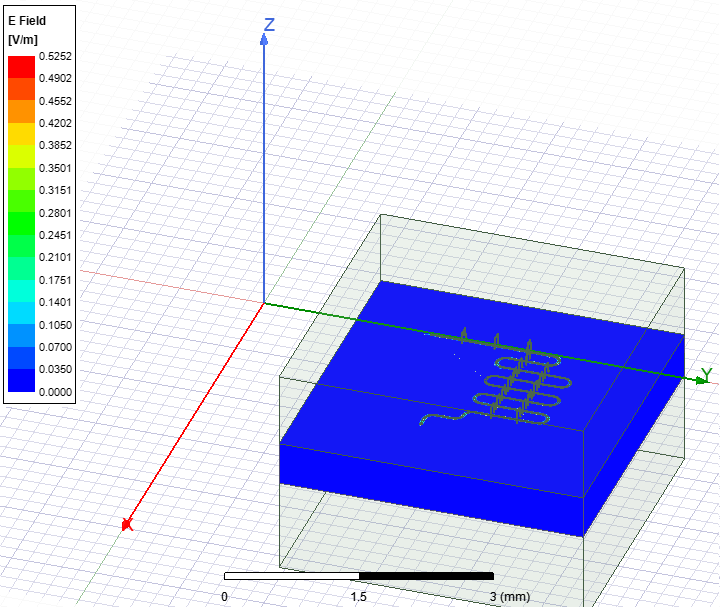

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [279]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [280]:
hfss.epr_get_frequencies()

Design "cavity7-2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.363949,inf


In [300]:
hfss.activate_eigenmode_design("cavity8")

02:54PM 59s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:54PM 59s WARNING [activate_ansys_design]: The design_name=cavity8-4 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity7', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity11-2', 'cavity8-3', 'cavity8-2', 'cavity10-2'].  A new design will be added to the project.  
INFO 02:55PM [connect_design]: 	Opened active design
	Design:    cavity8-4 [Solution type: Eigenmode]
WARNING 02:55PM [connect_setup]: 	No design setup detected.
WARNING 02:55PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [301]:
hfss.render_design(['cavity8'], [('cavity8', 'end'), ('cavity8', 'start')])

In [302]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:56PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:00PM 07s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


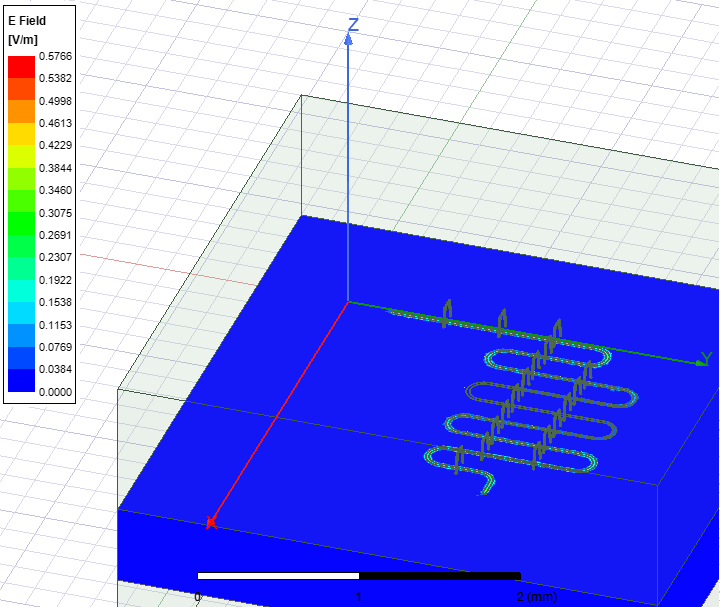

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [303]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [304]:
hfss.epr_get_frequencies()

Design "cavity8-4" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,5.96881,inf


In [286]:
hfss.activate_eigenmode_design("cavity10")

02:43PM 32s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:43PM 32s WARNING [activate_ansys_design]: The design_name=cavity10-2 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity7', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity8-3', 'cavity8-2'].  A new design will be added to the project.  
INFO 02:43PM [connect_design]: 	Opened active design
	Design:    cavity10-2 [Solution type: Eigenmode]
WARNING 02:43PM [connect_setup]: 	No design setup detected.
WARNING 02:43PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [287]:
hfss.render_design(['cavity10'], [('cavity10', 'end'), ('cavity10', 'start')])

In [288]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 02:44PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:47PM 12s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


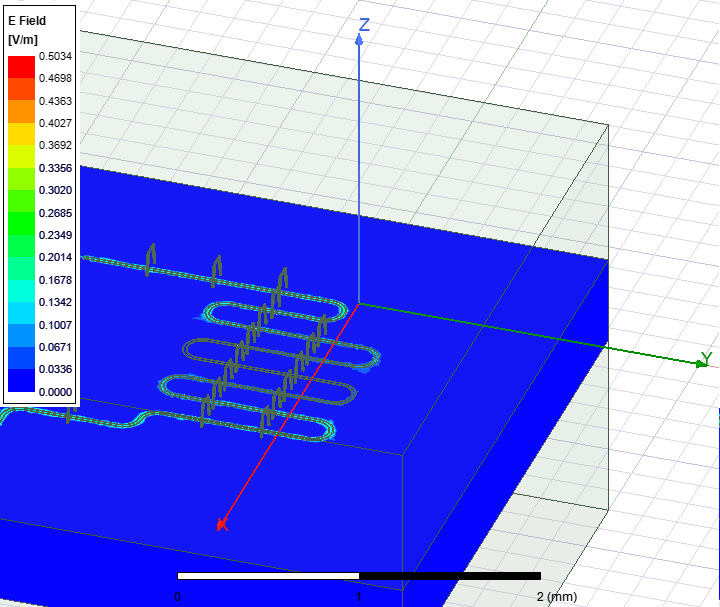

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [289]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [291]:
hfss.epr_get_frequencies()

Design "cavity10-2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,5.699254,inf


In [305]:
hfss.activate_eigenmode_design("cavity11")

03:00PM 41s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:00PM 41s WARNING [activate_ansys_design]: The design_name=cavity11-3 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity8-4', 'cavity7', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity11-2', 'cavity8-3', 'cavity8-2', 'cavity10-2'].  A new design will be added to the project.  
INFO 03:00PM [connect_design]: 	Opened active design
	Design:    cavity11-3 [Solution type: Eigenmode]
WARNING 03:00PM [connect_setup]: 	No design setup detected.
WARNING 03:00PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [306]:
hfss.render_design(['cavity11'], [('cavity11', 'end'), ('cavity11', 'start')])

In [307]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 03:01PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:05PM 41s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


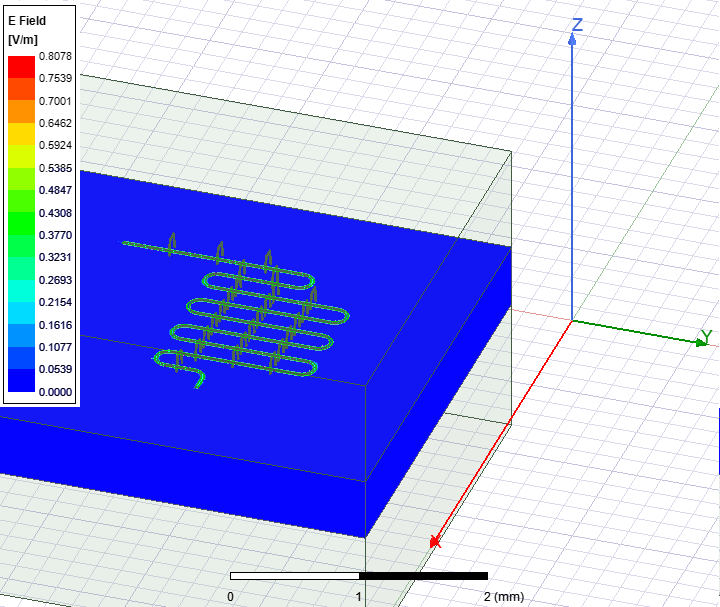

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [308]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [309]:
hfss.epr_get_frequencies()

Design "cavity11-3" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,5.195478,inf


In [297]:
QAnsysRenderer.get_template_options(design)

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [34]:
QAnsysRenderer.default_setup

{'drivenmodal': {'name': 'Setup',
  'freq_ghz': '5.0',
  'max_delta_s': '0.1',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '1'},
 'eigenmode': {'name': 'Setup',
  'min_freq_ghz': '1',
  'n_modes': '1',
  'max_delta_f': '0.5',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '-1'},
 'q3d': {'name': 'Setup',
  'freq_ghz': '5.0',
  'save_fields': 'False',
  'enabled': 'True',
  'max_passes': '15',
  'min_passes': '2',
  'min_converged_passes': '2',
  'percent_error': '0.5',
  'percent_refinement': '30',
  'auto_increase_solution_order': 'True',
  'solution_order': 'High',
  'solver_type': 'Iterative'},
 'port_inductor_gap': '10um'}

In [310]:
hfss.clean_active_design()

In [311]:
hfss.activate_eigenmode_design("Q7_Res7")

03:06PM 31s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:06PM 31s WARNING [activate_ansys_design]: The design_name=Q7_Res7-2 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity8-4', 'cavity7', 'cavity11-3', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity11-2', 'cavity8-3', 'cavity8-2', 'cavity10-2'].  A new design will be added to the project.  
INFO 03:06PM [connect_design]: 	Opened active design
	Design:    Q7_Res7-2 [Solution type: Eigenmode]
WARNING 03:06PM [connect_setup]: 	No design setup detected.
WARNING 03:06PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [312]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [313]:
 hfss.render_design(['Q7', 'cavity7', 'otg7s'],[('cavity7', 'end')])

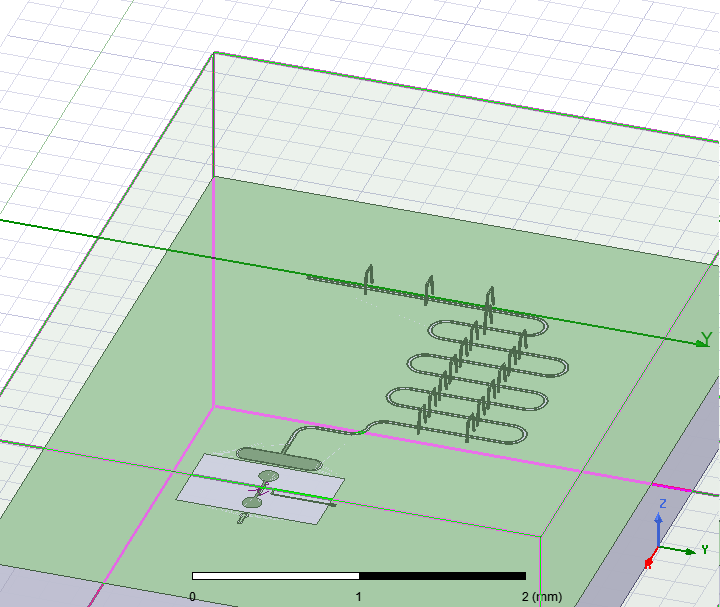

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [314]:
hfss.save_screenshot()

In [315]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:08PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:32PM 56s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



03:32PM 56s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


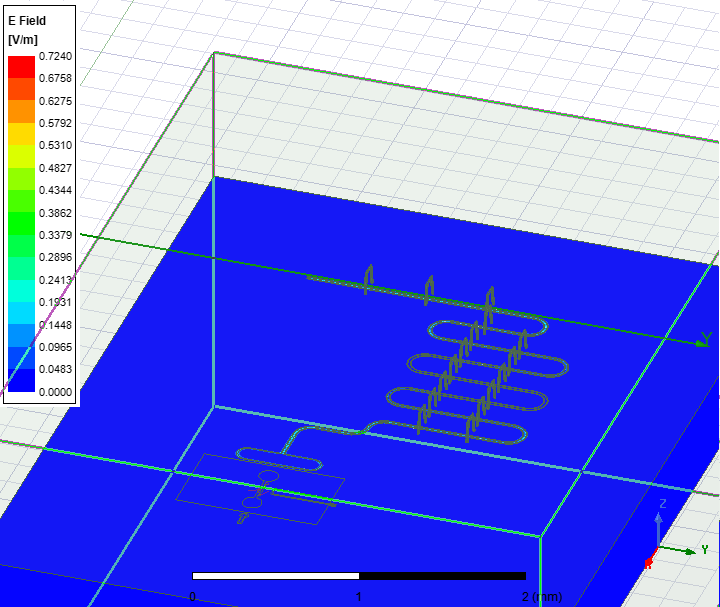

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [316]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [154]:
hfss.plot_ansys_delete(['Mag_E1'])

11:32PM 52s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [155]:
hfss.set_mode(2, "Setup")

INFO 11:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


11:33PM 07s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


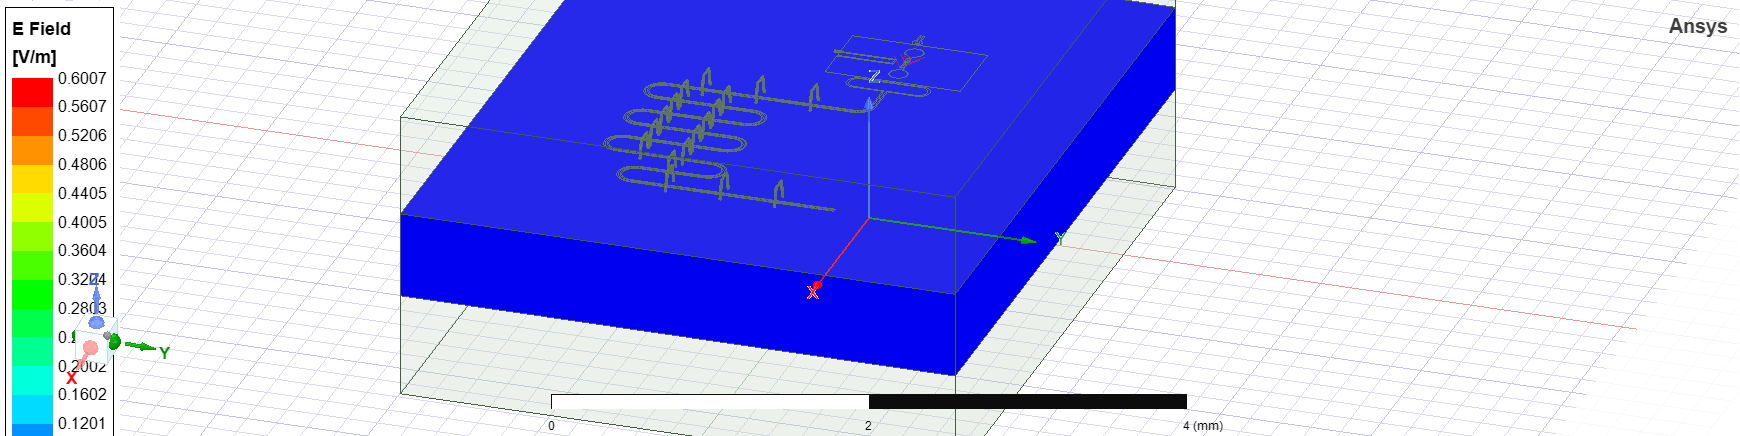

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [156]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [157]:
hfss.plot_ansys_delete(['Mag_E1'])

11:33PM 16s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [317]:
hfss.epr_get_frequencies()

Design "Q7_Res7-2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.751714             inf
          1        6.648719             inf

03:33PM 23s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [318]:
hfss.activate_eigenmode_design("Q8_Res8")

03:47PM 27s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:47PM 27s WARNING [activate_ansys_design]: The design_name=Q8_Res8-2 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity8-4', 'cavity7', 'cavity11-3', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity11-2', 'Q7_Res7-2', 'cavity8-3', 'cavity8-2', 'cavity10-2'].  A new design will be added to the project.  
INFO 03:47PM [connect_design]: 	Opened active design
	Design:    Q8_Res8-2 [Solution type: Eigenmode]
WARNING 03:47PM [connect_setup]: 	No design setup detected.
WARNING 03:47PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [319]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [320]:
hfss.render_design(['Q8', 'cavity8', 'otg8s'],[('cavity8', 'end')])

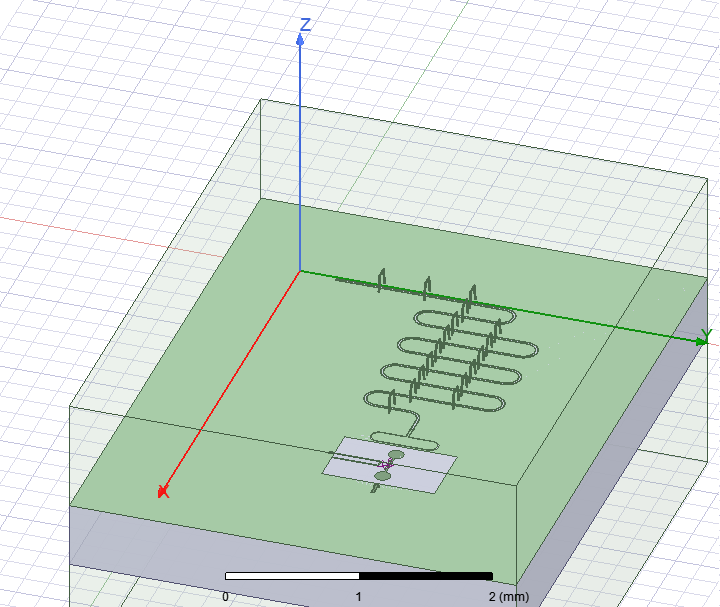

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [321]:
hfss.save_screenshot()

In [322]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:49PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:03PM 58s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


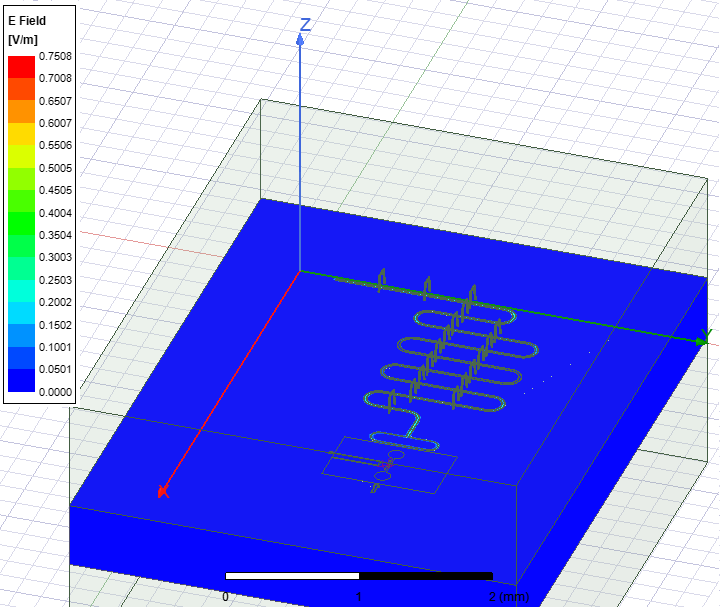

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [323]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [165]:
hfss.plot_ansys_delete(['Mag_E1'])

01:24AM 34s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [166]:
hfss.set_mode(2, "Setup")

INFO 01:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


01:24AM 37s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


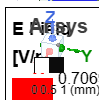

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [167]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [168]:
hfss.plot_ansys_delete(['Mag_E1'])

01:24AM 43s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [324]:
hfss.epr_get_frequencies()

Design "Q8_Res8-2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.437556             inf
          1        6.540865             inf

In [325]:
hfss.activate_eigenmode_design("Q10_Res10")

04:04PM 24s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:04PM 24s WARNING [activate_ansys_design]: The design_name=Q10_Res10-2 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity8-4', 'cavity7', 'cavity11-3', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity11-2', 'Q7_Res7-2', 'cavity8-3', 'Q8_Res8-2', 'cavity8-2', 'cavity10-2'].  A new design will be added to the project.  
INFO 04:04PM [connect_design]: 	Opened active design
	Design:    Q10_Res10-2 [Solution type: Eigenmode]
WARNING 04:04PM [connect_setup]: 	No design setup detected.
WARNING 04:04PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [326]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [327]:
hfss.render_design(['Q10', 'cavity10', 'otg10s'],[('cavity10', 'end')])

In [328]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 04:08PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:29PM 26s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


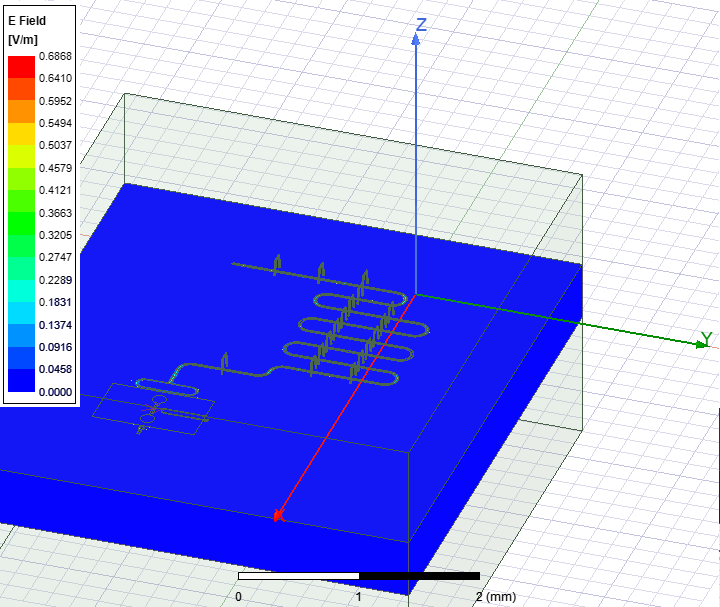

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

04:29PM 38s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [329]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [330]:
hfss.plot_ansys_delete(['Mag_E1'])

04:29PM 38s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [202]:
hfss.set_mode(2, "Setup")

INFO 03:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


03:29AM 03s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


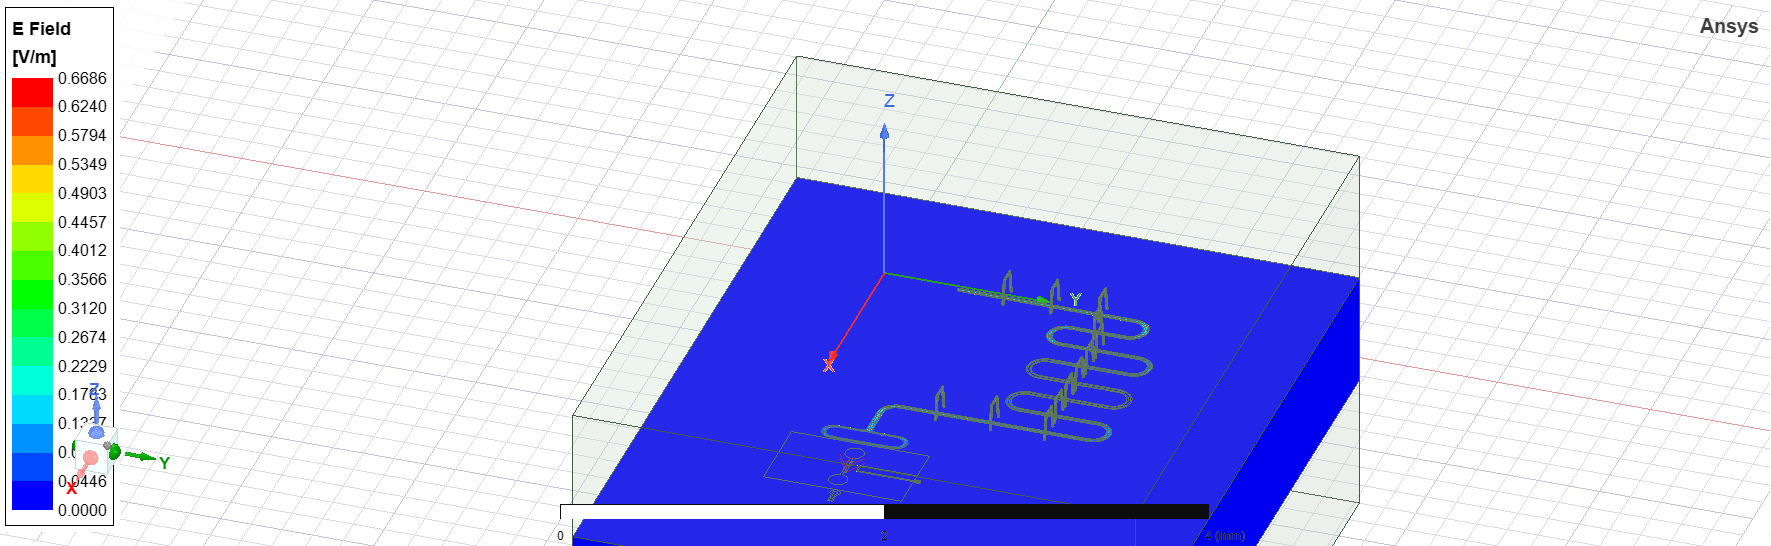

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [203]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [204]:
hfss.plot_ansys_delete(['Mag_E1'])

03:29AM 19s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [331]:
hfss.epr_get_frequencies()

Design "Q10_Res10-2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.186190             inf
          1        6.681795             inf

In [333]:
hfss.activate_eigenmode_design("Q11_Res11")

04:30PM 15s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:30PM 15s WARNING [activate_ansys_design]: The design_name=Q11_Res11-2 was not in active project.  Designs in active project are: 
['Design_q3d', 'cavity11', 'cavity10', 'Q7_Res7', 'Q8_Res8', 'Q10_Res10', 'cavity8-4', 'cavity7', 'cavity11-3', 'cavity8', 'Q11_Res11', 'cavity7-2', 'cavity11-2', 'Q7_Res7-2', 'cavity8-3', 'Q8_Res8-2', 'cavity8-2', 'cavity10-2', 'Q10_Res10-2'].  A new design will be added to the project.  
INFO 04:30PM [connect_design]: 	Opened active design
	Design:    Q11_Res11-2 [Solution type: Eigenmode]
WARNING 04:30PM [connect_setup]: 	No design setup detected.
WARNING 04:30PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [334]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [335]:
hfss.render_design(['Q11', 'cavity11', 'otg11s'],[('cavity11', 'end')])

In [336]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 04:34PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:49PM 55s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


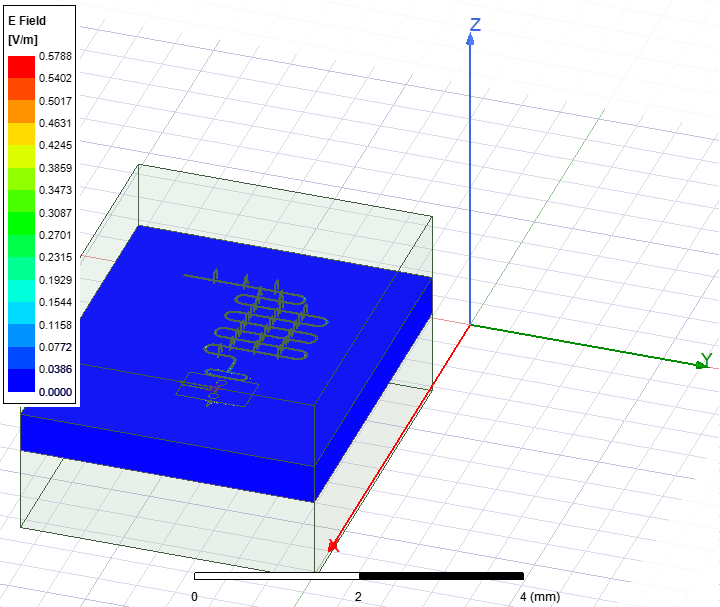

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [337]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [187]:
hfss.plot_ansys_delete(['Mag_E1'])

02:24AM 09s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [188]:
hfss.set_mode(2, "Setup")

INFO 02:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


02:24AM 12s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


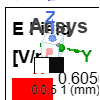

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [189]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [338]:
hfss.epr_get_frequencies()

Design "Q11_Res11-2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        4.778953             inf
          1        6.597102             inf

## Making the GDS file

In [28]:
fluxonium_gds = design.renderers.gds
fluxonium_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [29]:
import os; os.getcwd()

'C:\\Users\\figenyilmaz\\Desktop\\GitLab\\qiskit-metal\\2FX_with_Tmon'

In [33]:
fluxonium_gds.options['path_filename'] = 'FXTFX24-W7-02-V3.1-JJgdscells_ArrayJJ_V2.2.gds'

In [34]:
fluxonium_gds.options['fabricate'] = True

In [35]:
fluxonium_gds.export_to_gds('FXTFX24-W7-02-V3.1.gds')

09:46AM 31s WARNING [_give_rotation_center_twopads]: In junction table, component=Q1 with name=inductor has width=0.001 smaller than cell dimension=0.017.
09:46AM 31s WARNING [_give_rotation_center_twopads]: In junction table, component=Q2 with name=inductor has width=0.001 smaller than cell dimension=0.017.
09:46AM 31s WARNING [_give_rotation_center_twopads]: In junction table, component=Q4 with name=inductor has width=0.001 smaller than cell dimension=0.017.
09:46AM 31s WARNING [_give_rotation_center_twopads]: In junction table, component=Q5 with name=inductor has width=0.001 smaller than cell dimension=0.017.
09:46AM 31s WARNING [_give_rotation_center_twopads]: In junction table, component=Q3 with name=rect_jj1 has width=0.003 smaller than cell dimension=0.0068000000000000005.
09:46AM 31s WARNING [_give_rotation_center_twopads]: In junction table, component=Q3 with name=rect_jj2 has width=0.003 smaller than cell dimension=0.0068000000000000005.
09:46AM 31s WARNING [_give_rotation_ce

1